In [223]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import folium
from pypsa.linopt import get_var, linexpr, define_constraints
from geopy.geocoders import Nominatim
from geopy import distance

%matplotlib inline

In [224]:
def get_electrical_data(years_elect):
    if years_elect == [2030]:
        return "C:/Users/work/pypsa_thesis/data/electrical/1_2030"
    elif years_elect == [2040]:
        return "C:/Users/work/pypsa_thesis/data/electrical/2_2040"
    elif years_elect == [2050]:
        return "C:/Users/work/pypsa_thesis/data/electrical/3_2050"


def get_hydrogen_data(scenario_h2, years_h2, h2_config):
    if scenario_h2 == 'TN-H2-G':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-PtG-PtL':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-Strom':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2050.csv",
                                    index_col=0)

    df_h2_demand = pd.DataFrame(load_data)
    df_h2_demand.index.names = ['location_name']
    df_h2_demand.reset_index(inplace=True)
    df_h2_demand.dropna(subset=['location_name'], inplace=True)

    for loc_count in range(len(df_h2_demand['location_name'])):
        geolocator = Nominatim(user_agent="locate_h2_demand")
        locate_h2_demand = geolocator.geocode(df_h2_demand['location_name'][loc_count].split(',')[0])
        df_h2_demand['x'][loc_count] = locate_h2_demand.longitude
        df_h2_demand['y'][loc_count] = locate_h2_demand.latitude

    df_ac_loads_h2_loads_dist = pd.DataFrame(index=network.loads.index, columns=df_h2_demand['location_name'])

    for city_count_x in range(len(network.loads.index)):
        for city_count_y in range(len(df_h2_demand['location_name'])):
            if network.loads.index[city_count_x] != df_h2_demand['location_name'][city_count_y]:
                city_1 = (network.loads['y'][city_count_x], network.loads['x'][city_count_x])
                city_2 = (df_h2_demand['y'][city_count_y], df_h2_demand['x'][city_count_y])
                dist_city1_city2 = distance.distance(city_1, city_2).km
                df_ac_loads_h2_loads_dist.at[
                    network.loads.index[city_count_x], df_h2_demand['location_name'][city_count_y]] = dist_city1_city2

    ac_loads_h2_links = []

    for column_count_x in df_ac_loads_h2_loads_dist.columns:
        for distance_count_x in range(len(df_ac_loads_h2_loads_dist[column_count_x])):
            if df_ac_loads_h2_loads_dist[column_count_x][distance_count_x] == \
                    df_ac_loads_h2_loads_dist[column_count_x].min():
                ac_loads_h2_links.append(df_ac_loads_h2_loads_dist.index[distance_count_x])

    ac_loads_h2_links = list(dict.fromkeys(ac_loads_h2_links))

    df_h2_buses_load = pd.DataFrame(index=ac_loads_h2_links, columns={'h2_load': [], 'x': [], 'y': []})

    for buses_count in range(len(network.buses.index)):
        for h2_buses_count in range(len(df_h2_buses_load.index)):
            if network.buses.index[buses_count] == df_h2_buses_load.index[h2_buses_count]:
                df_h2_buses_load['x'][h2_buses_count] = network.buses['x'][buses_count]
                df_h2_buses_load['y'][h2_buses_count] = network.buses['y'][buses_count]

    df_h2_buses_load.fillna(0, inplace=True)

    for column_count_y, i_count_y in zip(df_ac_loads_h2_loads_dist.columns, range(len(df_h2_demand['location_name']))):
        for distance_count_y in range(len(df_ac_loads_h2_loads_dist[column_count_y])):
            if df_ac_loads_h2_loads_dist[column_count_y][distance_count_y] == \
                    df_ac_loads_h2_loads_dist[column_count_y].min():
                h2_load_value = df_h2_demand[df_h2_demand['location_name'] == column_count_y]['demand_value'][
                                    i_count_y] * 1e6  # in MWh
                h2_demand_loc = df_ac_loads_h2_loads_dist.index[distance_count_y]
                if df_h2_buses_load.at[h2_demand_loc, 'h2_load'] == 0:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = h2_load_value
                else:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = df_h2_buses_load.at[h2_demand_loc, 'h2_load'] + \
                                                                    h2_load_value

    df_h2_pipelines_dist = pd.DataFrame(index=ac_loads_h2_links, columns=ac_loads_h2_links)

    for column_count_z in range(len(list(df_h2_pipelines_dist.index))):
        for row_count_z in range(len(list(df_h2_pipelines_dist.columns))):
            if df_h2_pipelines_dist.index[column_count_z] != df_h2_pipelines_dist.columns[row_count_z]:
                loc_1 = (df_h2_buses_load['y'][column_count_z], df_h2_buses_load['x'][column_count_z])
                loc_2 = (df_h2_buses_load['y'][row_count_z], df_h2_buses_load['x'][row_count_z])
                dist_loc_1_loc_2 = distance.distance(loc_1, loc_2).km
                df_h2_pipelines_dist.at[
                    df_h2_pipelines_dist.columns[row_count_z], df_h2_pipelines_dist.index[column_count_z]] = \
                    dist_loc_1_loc_2

    if h2_config == 'short':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_p in list(df_h2_pipelines_dist.columns):
            for city_count_q in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_p][city_count_q] == \
                        df_h2_pipelines_dist[city_count_p].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_p, df_h2_pipelines_dist.index[city_count_q]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_p))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_q]))
                    bus_0_list.append(city_count_p)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_q])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_p].min())

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'all':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_r in list(df_h2_pipelines_dist.columns):
            for city_count_s, i_count_s in zip(list(df_h2_pipelines_dist.index), range(len(list(df_h2_pipelines_dist.index)))):
                if city_count_r != city_count_s:
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_r, city_count_s))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_r))
                    h2_bus_1_list.append('{}_H2_Bus'.format(city_count_s))
                    bus_0_list.append(city_count_r)
                    bus_1_list.append(city_count_s)
                    distance_km_list.append(df_h2_pipelines_dist[city_count_r][i_count_s])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'short_fnb_2030':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_a in list(df_h2_pipelines_dist.columns):
            for city_count_b in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_a][city_count_b] == \
                        df_h2_pipelines_dist[city_count_a].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_a, df_h2_pipelines_dist.index[city_count_b]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_a))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_b]))
                    bus_0_list.append(city_count_a)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_b])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_a].min())

        # below connections currently for BW
        fnb_2030_add = [['Eichstetten_110kV', 'Lorrach_110kV'],
                        ['KarlsruheWest_110kV', 'HeidelburgSud_110kV'],
                        ['HeidelburgSud_110kV', 'Grossgartach_110kV'],
                        ['Grossgartach_110kV', 'Kupferzell_110kV'],
                        ['Sindelfingen_110kV', 'Birkenfeld_110kV'],
                        ['Sindelfingen_110kV', 'Oberjettingen_110kV'],
                        ['Reutlingen_110kV', 'Laufen_an_der_Eyach_110kV'],
                        ['Sipplingen_110kV', 'Markdorf_110kV'],
                        ['Biberach_110kV', 'Ravensburg_110kV'],
                        ['Goldshofe_110kV', 'Giengen_110kV']]

        for city_add in range(len(fnb_2030_add)):
            h2_pipe_row_list.append('{}_{}_h2_pipe'.format(fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]))
            h2_bus_0_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][0]))
            h2_bus_1_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][1]))
            bus_0_list.append(fnb_2030_add[city_add][0])
            distance_km_list.append(df_h2_pipelines_dist.at[fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    all_bus_list = bus_0_list + bus_1_list
    connected_list = []

    for city_check in ac_loads_h2_links:
        if city_check not in all_bus_list:
            print('{} not connected to any bus'.format(city_check))
        else:
            connected_list.append('{} is connected to a H2 bus'.format(city_check))

    dict_h2_data = {'h2_links': ac_loads_h2_links,
                    'h2_dataframe': df_h2_demand,
                    'h2_buses_load': df_h2_buses_load,
                    'h2_pipelines': df_h2_pipelines,
                    'h2_demand_value_total': round(sum(df_h2_demand['demand_value']) * 1e6, 2)}  # in MWh

    return dict_h2_data


# user input for:
# years to simulate
# which h2 demand scenario
# which h2 pipeline connection configuration
# resolution in 1 year simulation - current: 24 hours / daily

# choose which year to simulate

years = [2040]  # [2030] or [2040] or [2050]

# choose which hydrogen demand scenario to simulate

h2_scenario_demand = "TN-H2-G"  # "TN-H2-G" or "TN-PtG-PtL" or "TN-Strom"

# choose configuration of h2 pipelines connection:
# 'short' - buses which have h2 demand (which is h2 buses), will connect to any h2 buses in the shortest distance
# 'all' - each h2 buses will connect to all other h2 buses regardless of short/long distances
# 'short_fnb_2030' - connects using 'short' config first and then follows roughly similar to proposed h2 pipeline
#                    connection based on FNB gas network development plan 2020 - 2030

h2_pipe_config = 'short'

# choose resolution

freq = "24"

### case - 1 ###

network = pypsa.Network(get_electrical_data(years))

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(start='{}-01-01 00:00'.format(year),
                           freq='{}H'.format(freq),
                           periods=8760 / float(freq))
    snapshots = snapshots.append(period)

network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

# network.snapshots

network.loads_t.p_set = pd.DataFrame(index=network.snapshots,
                                     columns=network.loads.index,
                                     data=1000 * np.random.rand(len(network.snapshots), len(network.loads)))

'''

Nyears value depends on the snapshot resolution freq variable
current freq = 24 with Nyears value of = 0.041666666666666664
Change of Nyears value will affect the calculation of capital cost using pypsa-eur methodology from 
the add_electricity script

Nyears = network.snapshot_weightings.objective.sum() / 8760
Nyears

costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) + 
                            costs["FOM"]/100.) *
                            costs["investment"] * Nyears)
                            
'''

pmaxpu_generators = network.generators[
    (network.generators['carrier'] == 'Solar') |
    (network.generators['carrier'] == 'Wind_Offshore') |
    (network.generators['carrier'] == 'Wind_Onshore')]

network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=pmaxpu_generators.index)

network.generators_t.p_max_pu.loc[:, pmaxpu_generators.index] = pd.DataFrame(index=network.snapshots,
                                                                             columns=pmaxpu_generators.index,
                                                                             data=np.random.rand(len(network.snapshots),
                                                                                                 len(pmaxpu_generators)))

h2_data = get_hydrogen_data(h2_scenario_demand, years, h2_pipe_config)

# connect between electrical buses and hydrogen bus via link (as electrolysis unit)

network.add('Bus', 'Hydrogen', carrier='Hydrogen', x=8.5, y=49.0)

link_buses = h2_data['h2_links']

link_names = [s + '_Electrolysis' for s in link_buses]

# electrolysis capital cost and efficiency are based on DEA agency data and pypsa methodology calculations

electrolysis_cap_cost = 0
electrolysis_efficiency = 0

if years == [2030]:
    electrolysis_cap_cost = 1886
    electrolysis_efficiency = 0.68
elif years == [2040]:
    electrolysis_cap_cost = 1238.41
    electrolysis_efficiency = 0.72
elif years == [2050]:
    electrolysis_cap_cost = 1012.85
    electrolysis_efficiency = 0.75

network.madd('Link',
             link_names,
             carrier='Hydrogen',
             capital_cost=electrolysis_cap_cost,
             p_nom_extendable=True,
             bus0=link_buses,
             bus1='Hydrogen',
             efficiency=electrolysis_efficiency)

network.add('Store', 'Store_Hydrogen', bus='Hydrogen', carrier='Hydrogen', e_nom_extendable=True)

INFO:pypsa.io:Imported network 2_2040 has buses, carriers, generators, global_constraints, lines, loads, storage_units, transformers
C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_6532\3577242247.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_6532\3577242247.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [225]:
def hydrogen_constraints(n, snapshots):
    electrolysis_index = n.links.query('carrier == "Hydrogen"').index
    electrolysis_vars = get_var(n, 'Link', 'p').loc[n.snapshots[:], electrolysis_index]
    lhs = linexpr((1, electrolysis_vars)).sum().sum()
    total_production = h2_data['h2_demand_value_total']

    define_constraints(n, lhs, '>=', total_production, 'Link', 'global_hydrogen_production_goal')


def extra_functionality(n, snapshots):
    hydrogen_constraints(n, snapshots)

network.lopf(extra_functionality=extra_functionality, pyomo=False, solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\HPELIT~1\AppData\Local\Temp\pypsa-problem-e2gvppcr.lp
Reading time = 2.03 seconds
obj: 376682 rows, 144922 columns, 1167627 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 376682 rows, 144922 columns and 1167627 nonzeros
Model fingerprint: 0xee65dfde
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+08, 1e+08]
  RHS range        [2e-02, 3e+07]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 283262 rows and 54269 columns
Presolve time: 2.26s
Presolved: 93420 rows, 90653 columns, 643068 nonzeros

Ordering time: 0.65s

Barrier statistics:
 Dense cols : 148
 Free vars  : 31389
 AA' NZ     : 8.128e+05
 Factor NZ  : 4.069e+06 (roughly 100 MB of memory)
 Factor Ops : 5.930e+08 (less than 1 second per iteration)
 Threads    : 1

 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e+08


('ok', 'optimal')

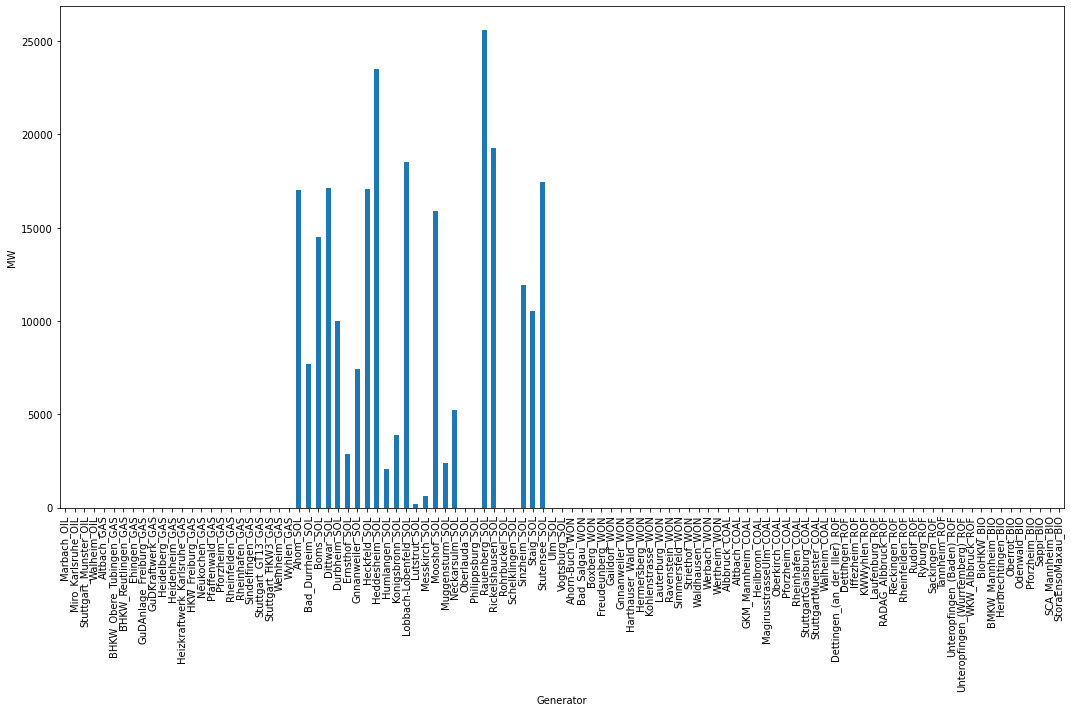

In [226]:
network.generators.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()

In [227]:
all_carr = list(network.carriers.index)

In [228]:
gen_carr = list(np.unique(list(network.generators.carrier)))
gen_carr

['Biomass', 'Coal', 'Gas', 'Oil', 'Run_of_River', 'Solar', 'Wind_Onshore']

In [229]:
df_gen_p_nom_opt = pd.DataFrame(index=gen_carr)

In [230]:
gen_p_nom_opt_list = []
gen_p_nom_list = []

for carr_count_x in range(len(gen_carr)):
    p_nom_opt_sum_x = network.generators[network.generators['carrier'] == '{}'.format(gen_carr[carr_count_x])]['p_nom_opt'].sum()
    p_nom_sum_x = network.generators[network.generators['carrier'] == '{}'.format(gen_carr[carr_count_x])]['p_nom'].sum()
    gen_p_nom_opt_list.append(round(p_nom_opt_sum_x,2))
    gen_p_nom_list.append(round(p_nom_sum_x,2))
    

df_gen_p_nom_opt['capacity p_nom_sum (MW)'] = gen_p_nom_list
df_gen_p_nom_opt['p_nom_opt_sum (MW)'] = gen_p_nom_opt_list  

df_gen_p_nom_opt

,capacity p_nom_sum (MW),p_nom_opt_sum (MW)
Biomass,264.8,0.00
Coal,5961.7,0.00
Gas,1194.9,0.00
Oil,701.8,0.00
Run_of_River,612.0,0.00
Solar,150.0,250836.43
Wind_Onshore,261.5,0.00


In [231]:
network.generators.p_nom_opt.sort_values(ascending=False)

Generator
Rauenberg_SOL            25580.069091
Heddesheim_SOL           23507.502321
Rickelshausen_SOL        19246.232202
Lobbach-Lobenfeld_SOL    18545.649556
Stutensee_SOL            17471.393424
                             ...     
Rohrbuckel_SOL               0.000000
Philippsburg_SOL             0.000000
Oberlauda_SOL                0.000000
Wyhlen_GAS                   0.000000
StoraEnsoMaxau_BIO           0.000000
Name: p_nom_opt, Length: 103, dtype: float64

In [232]:
su_unit_carr = list(np.unique(list(network.storage_units.carrier)))
su_unit_carr

['Pumped_Storage']

In [233]:
df_stor_unit_p_nom_opt = pd.DataFrame(index=su_unit_carr)

In [234]:
su_p_nom_opt_list = []
su_p_nom_list = []

for carr_count_y in range(len(su_unit_carr)):
    p_nom_opt_sum_y = network.storage_units[network.storage_units['carrier'] == '{}'.format(su_unit_carr[carr_count_y])]['p_nom_opt'].sum()
    p_nom_sum_y = network.storage_units[network.storage_units['carrier'] == '{}'.format(su_unit_carr[carr_count_y])]['p_nom'].sum()
    su_p_nom_opt_list.append(round(p_nom_opt_sum_y,2))
    su_p_nom_list.append(round(p_nom_sum_y,2))
    

df_stor_unit_p_nom_opt['capacity p_nom_sum (MW)'] = su_p_nom_list
df_stor_unit_p_nom_opt['p_nom_opt_sum (MW)'] = su_p_nom_opt_list  

df_stor_unit_p_nom_opt        

,capacity p_nom_sum (MW),p_nom_opt_sum (MW)
Pumped_Storage,1875.0,0.0


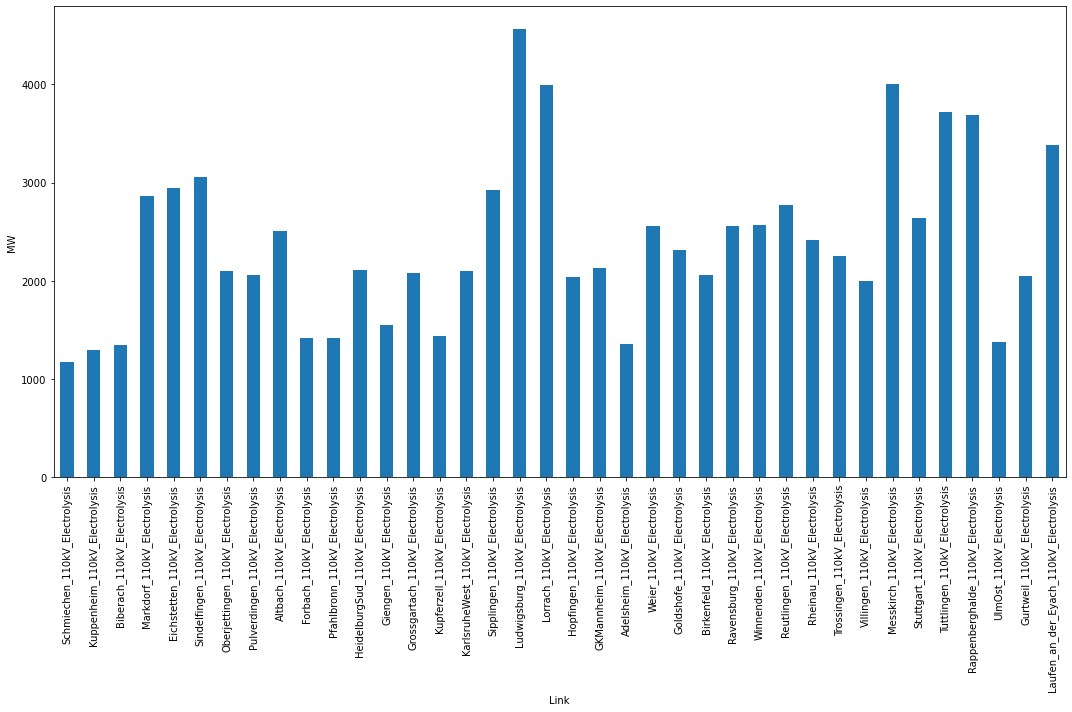

In [235]:
network.links.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()

In [236]:
network.links.p_nom_opt.sum()

90795.7304281547

In [237]:
network.links.p_nom_opt.sort_values(ascending=False)

Link
Ludwigsburg_110kV_Electrolysis            4567.066789
Messkirch_110kV_Electrolysis              4008.453272
Lorrach_110kV_Electrolysis                3994.705396
Tuttlingen_110kV_Electrolysis             3714.725491
Rappenberghalde_110kV_Electrolysis        3693.618090
Laufen_an_der_Eyach_110kV_Electrolysis    3381.233970
Sindelfingen_110kV_Electrolysis           3059.802206
Eichstetten_110kV_Electrolysis            2940.067919
Sipplingen_110kV_Electrolysis             2926.791977
Markdorf_110kV_Electrolysis               2859.156953
Reutlingen_110kV_Electrolysis             2767.584205
Stuttgart_110kV_Electrolysis              2638.057186
Winnenden_110kV_Electrolysis              2569.257063
Weier_110kV_Electrolysis                  2561.370851
Ravensburg_110kV_Electrolysis             2558.645445
Altbach_110kV_Electrolysis                2506.590565
Rheinau_110kV_Electrolysis                2417.822798
Goldshofe_110kV_Electrolysis              2313.248239
Trossingen_110kV_Electr

In [238]:
str_unit_carr = list(np.unique(list(network.stores.carrier)))

In [239]:
df_stor_p_nom_opt = pd.DataFrame(index=str_unit_carr)

In [240]:
str_p_nom_opt_list = []
str_p_nom_list = []

for carr_count_z in range(len(str_unit_carr)):
    p_nom_opt_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom_opt'].sum()
    p_nom_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom'].sum()
    str_p_nom_opt_list.append(round(p_nom_opt_sum_z,2))
    str_p_nom_list.append(round(p_nom_sum_z,2))
    

df_stor_p_nom_opt['capacity e_nom_sum (MWh)'] = str_p_nom_list
df_stor_p_nom_opt['e_nom_opt_sum (MWh)'] = str_p_nom_opt_list  

df_stor_p_nom_opt        

,capacity e_nom_sum (MWh),e_nom_opt_sum (MWh)
Hydrogen,0.0,20374051.12
